In [1]:
import numpy as np
import multiprocessing
from scipy import interpolate
from scipy.interpolate import make_interp_spline
from scipy import optimize
import matplotlib.pyplot as plt
import h5py
import os

In [3]:
checkpoint_dir = '/projects/bbvf/victoria/Transformer_training/inference/'

with h5py.File(os.path.join(checkpoint_dir, 'combined_results.h5'), 'r') as h5f:
    # Load the datasets"
    r_predictions = h5f['r_predictions'][:]
    c_predictions = h5f['c_predictions'][:]
    r_targets = h5f['r_targets'][:]
    c_targets = h5f['c_targets'][:]
    params = h5f['params'][:]

predictions = r_predictions + 1j * c_predictions
targets = r_targets + 1j * c_targets

print('number of samples: ', params.shape[0])

number of samples:  840512


waveform gallery:



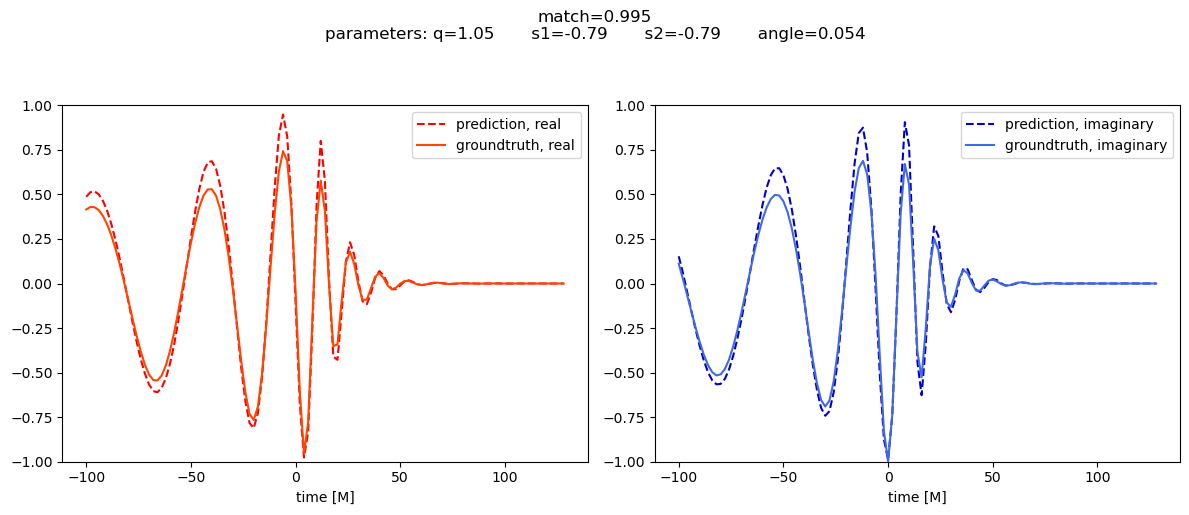

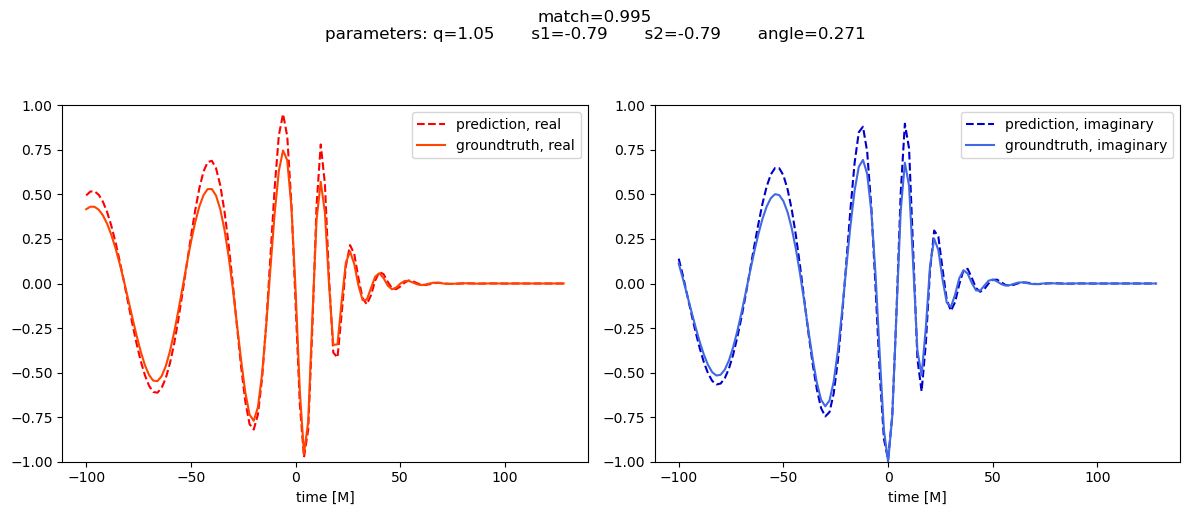

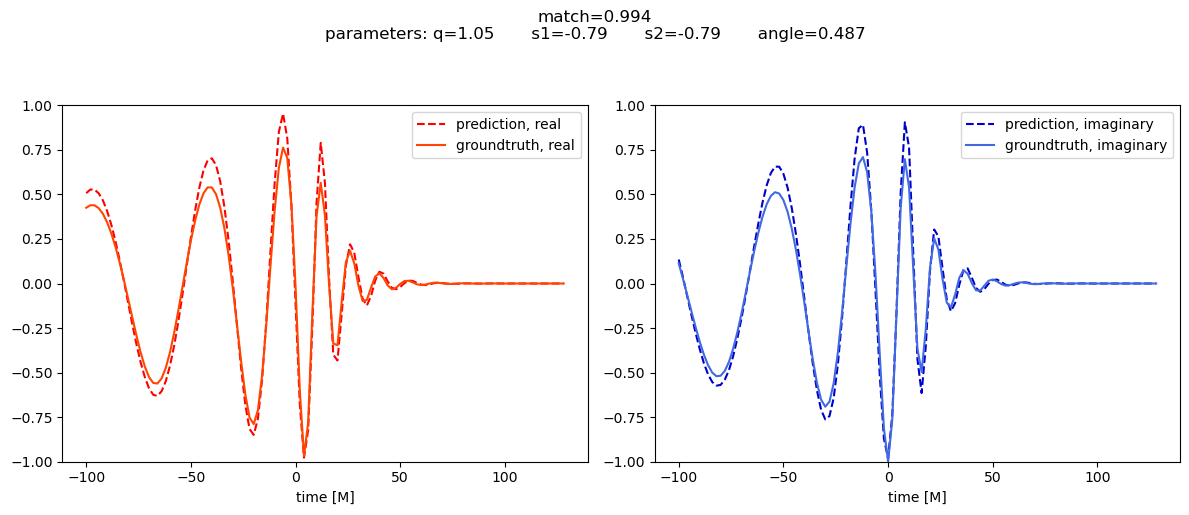

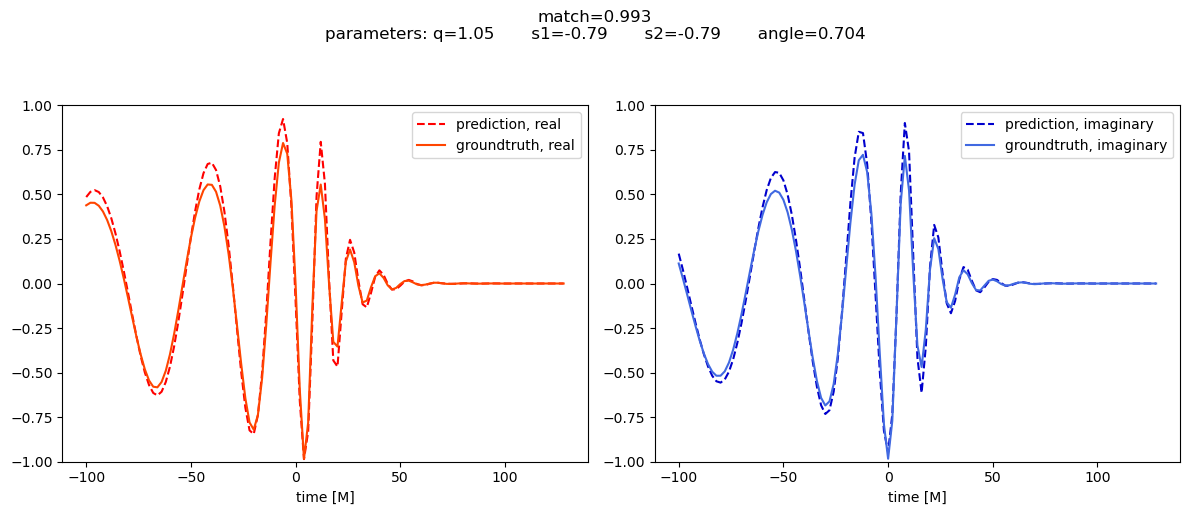

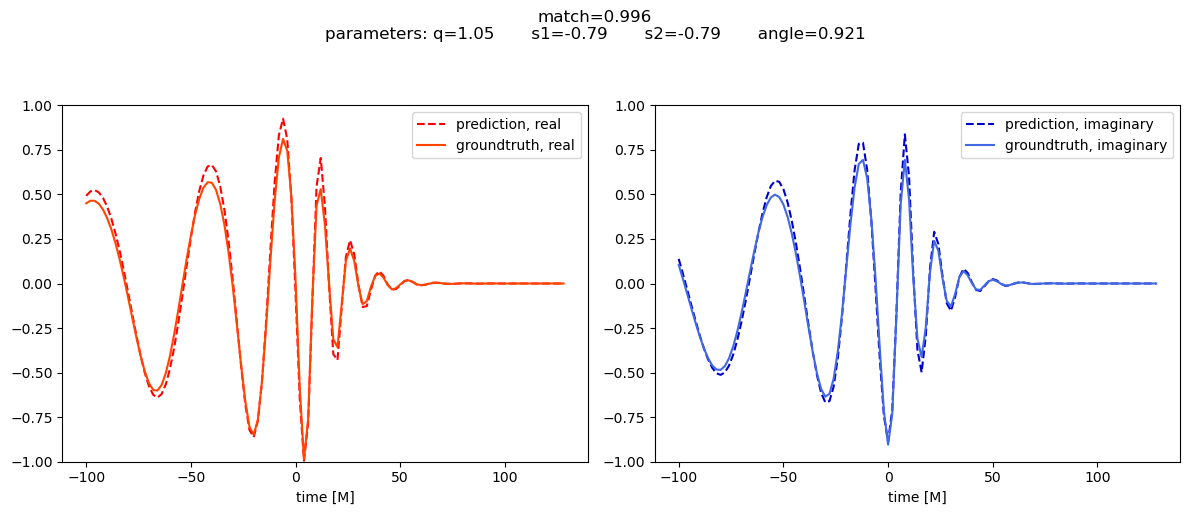

In [4]:
# Inner product between two waveforms assuming flat PSD
def InnerProduct(waveA, waveB, times):
    dT = times[1:] - times[:-1]
    return np.sum(dT * (waveA[:-1].real * waveB[:-1].real + waveA[:-1].imag * waveB[:-1].imag))

# Match between two waveforms assuming flat PSD
def Match(waveA, waveB, times):
    AB = InnerProduct(waveA, waveB, times)
    AA = InnerProduct(waveA, waveA, times)
    BB = InnerProduct(waveB, waveB, times)
    return (AB / np.sqrt(AA * BB))

# Function to time & phase shift, waveform
def timephaseshift(wave, times, deltaPhi, deltaT):
    tvals = times + deltaT
    hp = interpolate.InterpolatedUnivariateSpline(times, wave.real.astype('float64'), k=2)
    hpinterp = hp(tvals)
    hc = interpolate.InterpolatedUnivariateSpline(times, wave.imag.astype('float64'), k=2)
    hcinterp = hc(tvals)
    shifted=hpinterp+1.0j * hcinterp
    #shifted = (np.cos(deltaPhi) * hpinterp - np.sin(deltaPhi) * hcinterp) + 1.0j * (np.cos(deltaPhi) * hcinterp + np.sin(deltaPhi) * hpinterp)
    return shifted 

# Function to be minimized
def f(x, waveA, waveB, times):
    deltaPhi, deltaT = x
    aligned_wave = timephaseshift(waveA, times, deltaPhi, deltaT)
    return -Match(aligned_wave, waveB, times)

# Function to align and compute match
def align_and_match(wfl, wfp, times):
    # Align the new predicted waveform to the existing target waveform
    op = optimize.fmin_tnc(f, np.array([0, 0]), args=(wfp, wfl, times), approx_grad=1, bounds=((-np.pi, np.pi), (-10.0, 10.0)), messages=0)
    deltaPhi, deltaT = op[0]
    aligned_wave = timephaseshift(wfp, times, deltaPhi, deltaT)
    return aligned_wave

def compute_match(idx, return_waveforms=False):
    wf_l = targets[idx].copy()
    wf_p = predictions[idx].copy()
    
    times = np.arange(-10_000, 130, 1)
    times = times[::2]
    t = times[:len(wf_l)]
    
    # normalize both waveforms by the maximum value
    maxidx_l = np.argmax(wf_l.real**2 + wf_l.imag**2)
    norm_wfl = np.sqrt(wf_l.real[maxidx_l]**2 + wf_l.imag[maxidx_l]**2)
    wf_l /= norm_wfl
    
    maxidx_p = np.argmax(wf_p.real**2 + wf_p.imag**2)
    norm_wfp = np.sqrt(wf_p.real[maxidx_p]**2 + wf_p.imag[maxidx_p]**2)
    wf_p /= norm_wfp
    
    wf_p = align_and_match(wf_l, wf_p, t)
    
    # final match
    match = Match(wf_l, wf_p, t)
    
    if return_waveforms==True:
        return wf_l, wf_p, match
    else: 
        return match

# parallelize  computation
def compute_match_in_parallel(indices):
    with multiprocessing.Pool(processes=32) as pool:
        Ms = pool.map(compute_match, indices)
        
    return np.array(Ms)

def plot_overlaps(idx):
    wf_l, wf_p, match = compute_match(idx,return_waveforms=True)
    
    times = np.arange(-10_000, 130, 1)
    times = times[::2]
    t = times[-95:]

    wave_length = len(wf_l)
    t = times[:wave_length]
    
    match = round(match, 3)

    # extract parameters
    q, s1, s2, angle = map(float, params[idx])
    q = round(q, 3)
    s1 = round(s1, 3)
    s2 = round(s2, 3)
    angle = round(angle, 3)

    #  real part
    plt.figure(figsize=(12, 5))  

    plt.subplot(1, 2, 1)
    plt.plot(times[-len(wf_l):], wf_p.real, '--', c='r', label='prediction, real')
    plt.plot(times[-len(wf_l):], wf_l.real, c='orangered', label='groundtruth, real')
    plt.ylim([-1, 1])
    plt.legend()
    plt.xlabel('time [M]')

    #  imaginary part
    plt.subplot(1, 2, 2)
    plt.plot(times[-len(wf_l):], wf_p.imag, '--', c='mediumblue', label='prediction, imaginary')
    plt.plot(times[-len(wf_l):], wf_l.imag, c='royalblue', label='groundtruth, imaginary')
    plt.ylim([-1, 1])
    plt.legend()
    plt.xlabel('time [M]')

    combined_title = (
        f"match={match}\n"
        f"parameters: q={q:<10} s1={s1:<10}  s2={s2:<10}  angle={angle}\n"
    )

    plt.suptitle(combined_title, y=1.02, fontsize=12)  
    plt.tight_layout()  
    plt.show()


print('waveform gallery:\n')
for i in range(5):
    idx = i
    plot_overlaps(idx)

In [5]:
%%time

if __name__=='__main__':
    indices = np.arange(targets.shape[0]) #np.arange(0,10_000)
    Ms = compute_match_in_parallel(indices)

CPU times: user 3.55 s, sys: 448 ms, total: 4 s
Wall time: 6min 23s


In [6]:
print('median',np.median(Ms[~np.isnan(Ms)]))
print('mean',np.mean(Ms[~np.isnan(Ms)]))
print('number of waveforms ',Ms.shape[0])

median 0.9973800866359239
mean 0.9958736614994604
number of waveforms  840512


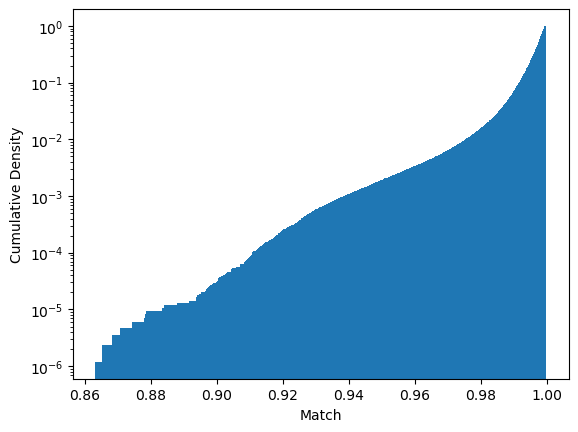

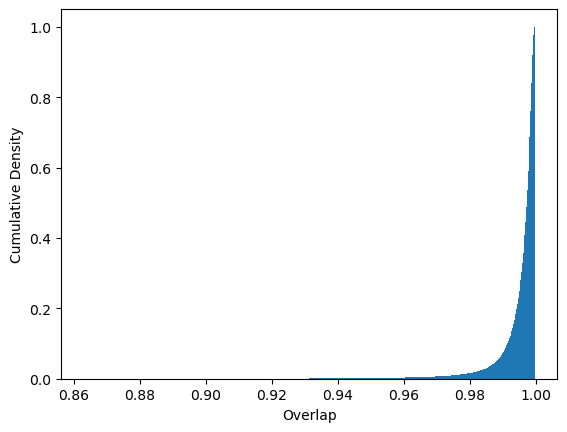

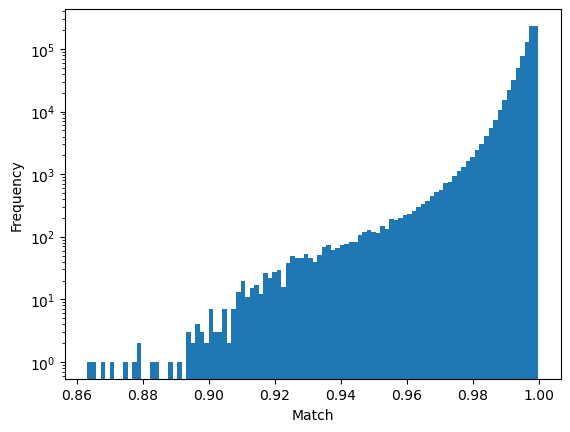

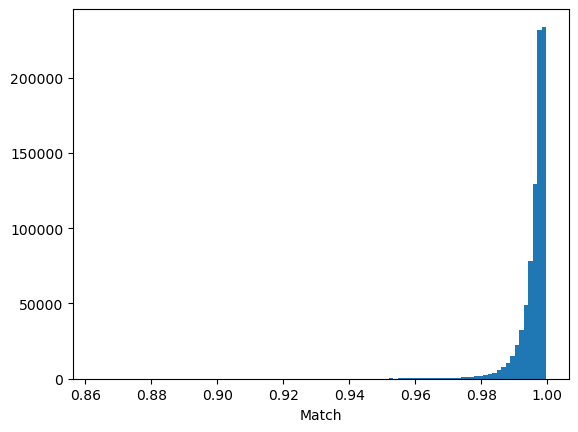

In [7]:
plt.hist(np.abs(Ms), bins=1000, cumulative=True,density=True)
plt.yscale('log')
plt.xlabel('Match')
plt.ylabel('Cumulative Density')
#plt.xlim([0.9,1])
plt.show()

plt.hist(np.abs(Ms), bins=1000, cumulative=True,density=True)
plt.xlabel('Overlap')
plt.ylabel('Cumulative Density')
#plt.xlim([0.9,1])
plt.show()

plt.hist(np.abs(Ms), bins=100, cumulative=False,density=False)
plt.xlabel('Match')
plt.yscale('log')
plt.ylabel('Frequency')
#plt.xlim([0.9,1])
plt.show()

plt.hist(np.abs(Ms), bins=100, cumulative=False,density=False)
plt.xlabel('Match')
#plt.xlim([0.9,1])
plt.show()

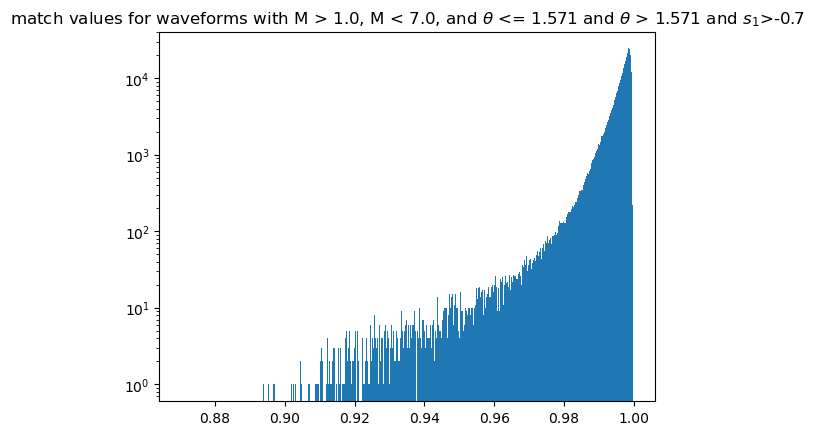

0.9972644304228813


In [8]:
delta_pi=0.0
M_max=7.0
M_min=1.
s_min=-0.7

mask_0th = params[:, 0] <= M_max
mask_1st = params[:, 0] >= M_min
mask_3rd = (params[:, 3] <= np.pi/2.0-delta_pi) | (params[:, 3] > np.pi/2.0+delta_pi)
mask_4th = params[:, 1] >= s_min

final_mask = mask_0th  & mask_1st & mask_3rd & mask_4th 

filtered_Ms = Ms[final_mask]

plt.hist(filtered_Ms, bins=1000, cumulative=False,density=False)
plt.yscale('log')
plt.title(rf'match values for waveforms with M > {M_min}, M < {M_max}, and $\theta$ <= {round(np.pi/2 - delta_pi,3)} and $\theta$ > {round(np.pi/2 + delta_pi,3)} and $s_1$>{s_min}')
plt.show()

print(np.median(filtered_Ms))


In [9]:
s=.995
print('\nnumber of matches over  '+str(s)+': '+str((Ms > s).sum()))
print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.995
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.99
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.98
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.95
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.9
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.8
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.5
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.4
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))


number of matches over  0.995: 638555
percent matches over 0.995: 75.97214554937942

number of matches below 0.995: 201957
percent matches under 0.995: 24.027854450620577

number of matches below 0.99: 60080
percent matches under 0.99: 7.148024061524404

number of matches below 0.98: 13362
percent matches under 0.98: 1.5897452981040128

number of matches below 0.95: 1632
percent matches under 0.95: 0.19416736465392523

number of matches below 0.9: 26
percent matches under 0.9: 0.0030933526231630244

number of matches below 0.8: 0
percent matches under 0.8: 0.0

number of matches below 0.5: 0
percent matches under 0.5: 0.0

number of matches below 0.4: 0
percent matches under 0.4: 0.0


In [10]:
for i in range (0,min(20,np.shape(np.where(Ms < .8)[0])[0])):
    plot_overlaps(np.where( Ms < .8)[0][i])

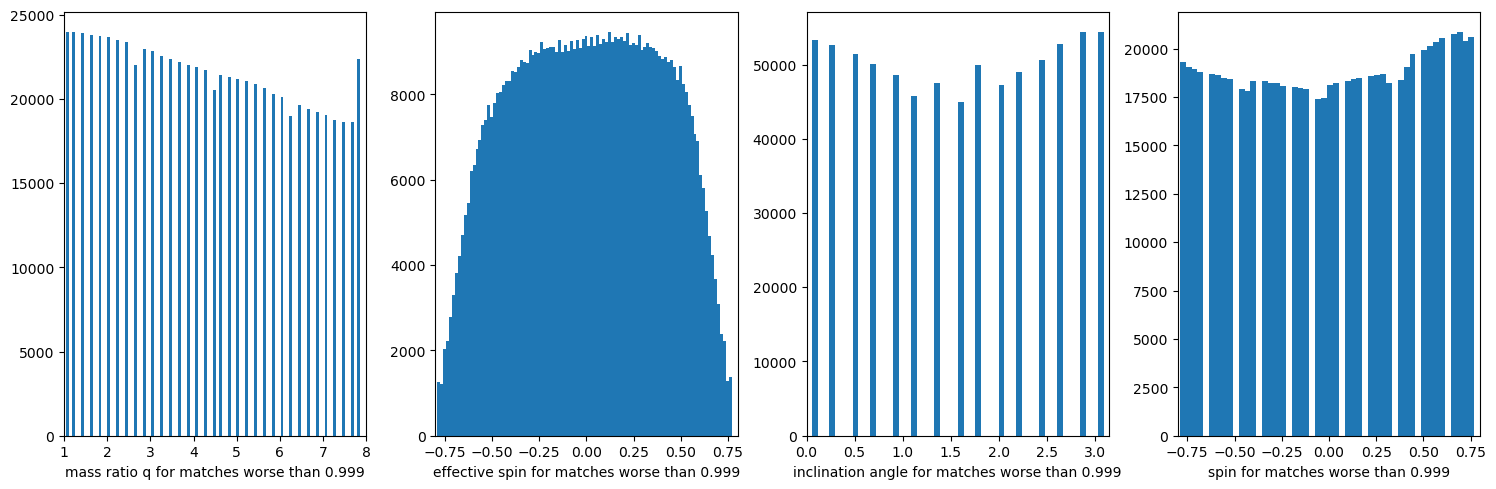

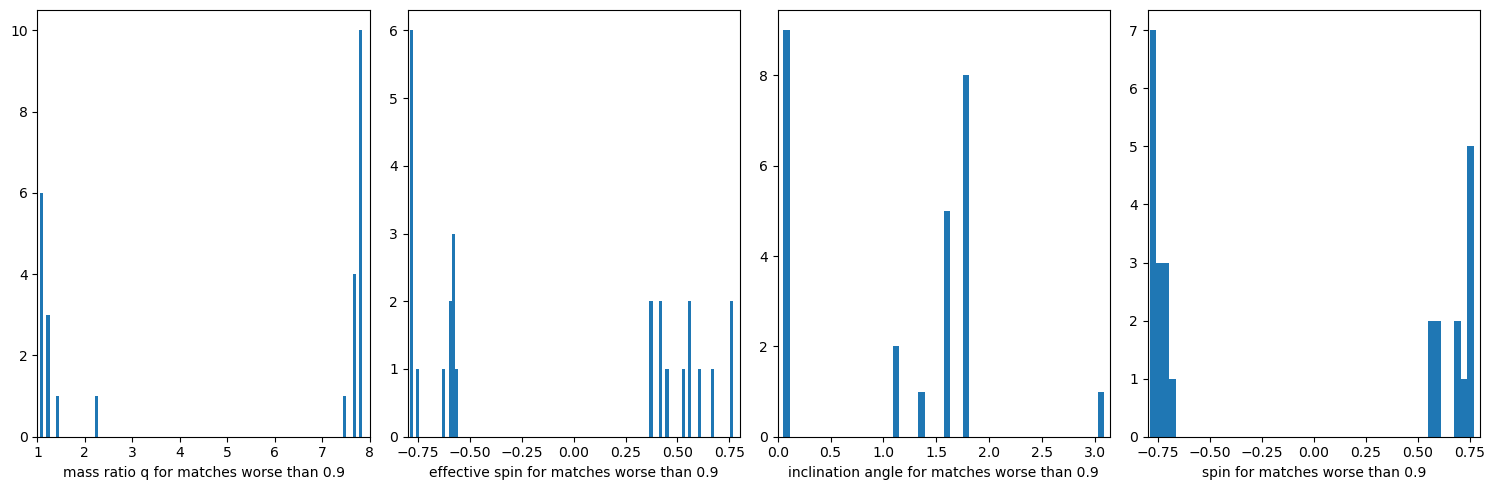

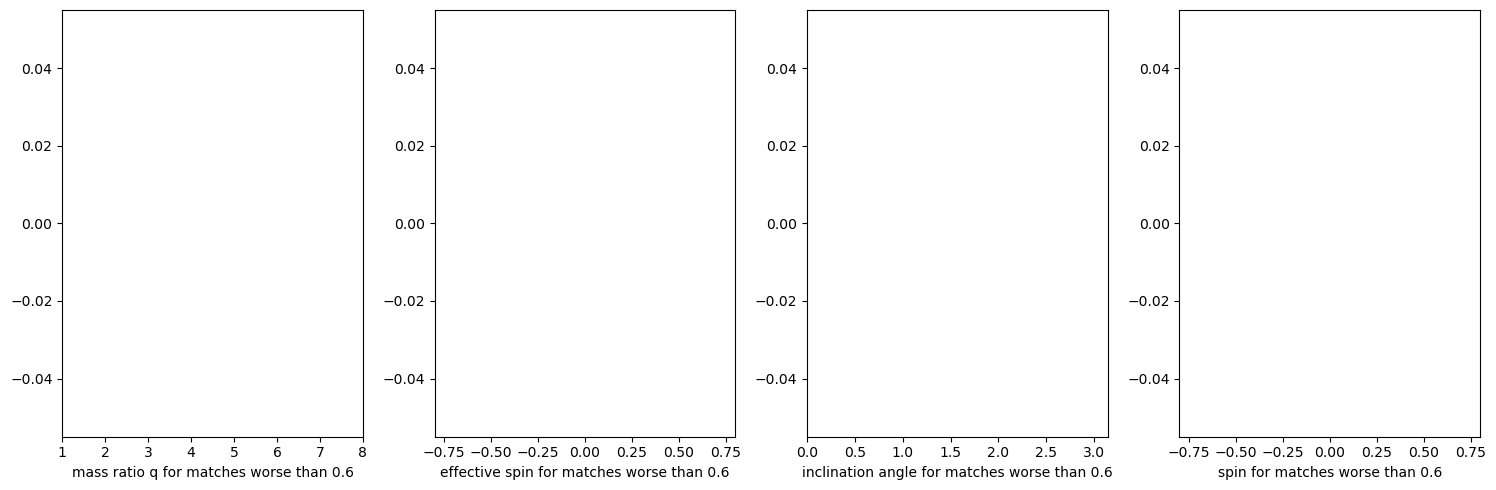

In [11]:
s=[0.999,0.9,0.6]
for i in range(0,len(s)):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Plot 1
    axs[0].hist(params[np.where(Ms < s[i])[0]][:, 0],bins=100)
    axs[0].set_xlabel('mass ratio q for matches worse than ' + str(s[i]))
    axs[0].set_xlim([1, 8])

    # Plot 2
    spin_eff = (params[np.where(Ms < s[i])[0]][:, 0] * params[np.where(Ms < s[i])[0]][:, 1] + params[np.where(Ms < s[i])[0]][:, 2]) / (1 + params[np.where(Ms < s[i])[0]][:, 0])
    axs[1].hist(spin_eff,bins=100)
    axs[1].set_xlabel('effective spin for matches worse than ' + str(s[i]))
    axs[1].set_xlim([-0.8, 0.8])

    # Plot 3
    axs[2].hist(params[np.where(Ms <= s[i])[0]][:, 3],bins=50)
    axs[2].set_xlabel('inclination angle for matches worse than ' + str(s[i]))
    axs[2].set_xlim([0, np.pi])
    
    
    axs[3].hist(params[np.where(Ms <= s[i])[0]][:, 1],bins=50)
    axs[3].set_xlabel('spin for matches worse than ' + str(s[i]))
    axs[3].set_xlim([-0.8, 0.8])


    plt.tight_layout()
    plt.show()


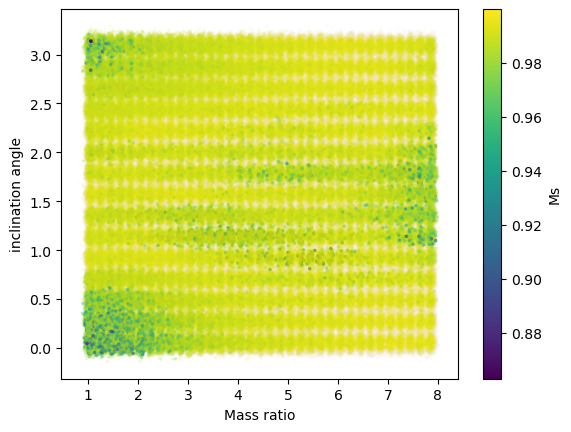

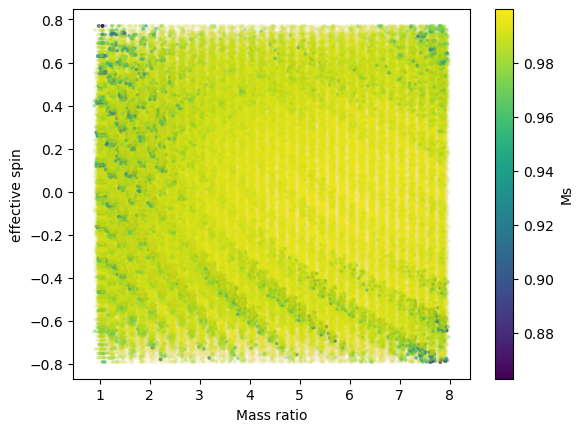

"spin_normalized = (params[:, 1] - params[:, 1].min()) / (params[:, 1].max() - params[:, 1].min())\nalpha_values = 1 - spin_normalized\nplt.scatter(params_jittered[:, 0], spin_eff, c=params[:, 1], cmap='viridis', s=3)\nplt.colorbar(label=rf'$s_1^z$')\nplt.xlabel('Mass ratio')\nplt.ylabel('effective spin')\nplt.show()\n\nplt.scatter(params_jittered[:, 3], spin_eff, c=Ms, cmap='viridis', alpha=alpha_values, s=3)\nplt.colorbar(label='Ms')\nplt.xlabel('Inclination angle')\nplt.ylabel('effective spin')\nplt.show()\n\n\nsym_mass=params[:, 0]/(1+params[:, 0])**2\nplt.scatter(sym_mass, spin_eff, c=Ms, cmap='viridis', alpha=alpha_values, s=3)\nplt.colorbar(label='Ms')\nplt.xlabel('symmetric mass ratio')\nplt.ylabel('effective spin')\nplt.show()"

In [12]:
jitter_amount = 0.05 
params_jittered = params.copy()
params_jittered[:, 0] += np.random.randn(params.shape[0]) * jitter_amount
params_jittered[:, 3] += np.random.randn(params.shape[0]) * jitter_amount

# Normalize values to range from 0 to 1
Ms_normalized = (Ms - Ms.min()) / (Ms.max() - Ms.min())

# Invert the normalized Ms values for alpha (0 for Ms=1 and 1 for Ms=min(Ms))
alpha_values = 1 - Ms_normalized

# Create scatter plot with jittered points and transparency
plt.scatter(params_jittered[:, 0], params_jittered[:, 3], c=Ms, cmap='viridis', alpha=alpha_values, s=3)
plt.colorbar(label='Ms')
plt.xlabel('Mass ratio')
plt.ylabel('inclination angle')
plt.show()

spin_eff = (params[:, 0] * params[:, 1] + params[:, 2]) / (1 + params[:, 0])

plt.scatter(params_jittered[:, 0], spin_eff, c=Ms, cmap='viridis', alpha=alpha_values, s=3)
plt.colorbar(label='Ms')
plt.xlabel('Mass ratio')
plt.ylabel('effective spin')
plt.show()
